##Team Member:
### Made Oka Resia Wedamerta (m.wedamerta@innopolis.university)
### Mahmoud Mousatat (m.mousatat@innopolis.university)

# Fake News Detection

##Implementation TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) is a commonly used technique in natural language processing for representing text data as a vector of numerical features. TF-IDF is good for fake news detection because it can capture the important words and phrases that distinguish fake news from real news.

TF-IDF works by assigning a weight to each word in a document based on its frequency in the document and its frequency in the corpus (collection of documents). Words that appear frequently in a document but rarely in the corpus are considered important and are assigned a high weight, while words that appear frequently in both the document and the corpus are considered less important and are assigned a low weight. This approach helps to identify words and phrases that are unique to a document and are therefore good indicators of its content.

In the context of fake news detection, TF-IDF can be used to represent each news article as a vector of numerical features that capture the important words and phrases in the article. This vector can then be used as input to a machine learning algorithm for classification. By comparing the TF-IDF vectors of different news articles, we can identify the words and phrases that are most characteristic of fake news and use them to train a model to distinguish fake news from real news.

Overall, TF-IDF is a powerful technique for analyzing text data and has been shown to be effective for fake news detection. However, it is important to note that TF-IDF alone may not be sufficient for detecting all instances of fake news, and additional features and techniques may be needed to improve the accuracy of the model.

In [ ]:
# Import relevant packages and modules
from csv import DictReader
from csv import DictWriter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf


# Initialise global variables
label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
label_ref_rev = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]


# Define data class
class FNCData:

    """

    Define class for Fake News Challenge data

    """

    def __init__(self, file_instances, file_bodies):

        # Load data
        self.instances = self.read(file_instances)
        bodies = self.read(file_bodies)
        self.heads = {}
        self.bodies = {}

        # Process instances
        for instance in self.instances:
            if instance['Headline'] not in self.heads:
                head_id = len(self.heads)
                self.heads[instance['Headline']] = head_id
            instance['Body ID'] = int(instance['Body ID'])

        # Process bodies
        for body in bodies:
            self.bodies[int(body['Body ID'])] = body['articleBody']

    def read(self, filename):

        """
        Read Fake News Challenge data from CSV file

        Args:
            filename: str, filename + extension

        Returns:
            rows: list, of dict per instance

        """

        # Initialise
        rows = []

        # Process file
        with open(filename, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)

        return rows


# Define relevant functions
def pipeline_train(train, test, lim_unigram):

    """

    Process train set, create relevant vectorizers

    Args:
        train: FNCData object, train set
        test: FNCData object, test set
        lim_unigram: int, number of most frequent words to consider

    Returns:
        train_set: list, of numpy arrays
        train_stances: list, of ints
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    """

    # Initialise
    heads = []
    heads_track = {}
    bodies = []
    bodies_track = {}
    body_ids = []
    id_ref = {}
    train_set = []
    train_stances = []
    cos_track = {}
    test_heads = []
    test_heads_track = {}
    test_bodies = []
    test_bodies_track = {}
    test_body_ids = []
    head_tfidf_track = {}
    body_tfidf_track = {}

    # Identify unique heads and bodies
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            heads.append(head)
            heads_track[head] = 1
        if body_id not in bodies_track:
            bodies.append(train.bodies[body_id])
            bodies_track[body_id] = 1
            body_ids.append(body_id)

    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in test_heads_track:
            test_heads.append(head)
            test_heads_track[head] = 1
        if body_id not in test_bodies_track:
            test_bodies.append(test.bodies[body_id])
            test_bodies_track[body_id] = 1
            test_body_ids.append(body_id)

    # Create reference dictionary
    for i, elem in enumerate(heads + body_ids):
        id_ref[elem] = i

    # Create vectorizers and BOW and TF arrays for train set
    bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
    bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only

    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

    tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).\
        fit(heads + bodies + test_heads + test_bodies)  # Train and test sets

    # Process train set
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        head_tf = tfreq[id_ref[head]].reshape(1, -1)
        body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
        if head not in head_tfidf_track:
            head_tfidf = tfidf_vectorizer.transform([head]).toarray()
            head_tfidf_track[head] = head_tfidf
        else:
            head_tfidf = head_tfidf_track[head]
        if body_id not in body_tfidf_track:
            body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
            body_tfidf_track[body_id] = body_tfidf
        else:
            body_tfidf = body_tfidf_track[body_id]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        train_set.append(feat_vec)
        train_stances.append(label_ref[instance['Stance']])

    return train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer


def pipeline_test(test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer):

    """

    Process test set

    Args:
        test: FNCData object, test set
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    Returns:
        test_set: list, of numpy arrays

    """

    # Initialise
    test_set = []
    heads_track = {}
    bodies_track = {}
    cos_track = {}

    # Process test set
    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            head_bow = bow_vectorizer.transform([head]).toarray()
            head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
            head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
            heads_track[head] = (head_tf, head_tfidf)
        else:
            head_tf = heads_track[head][0]
            head_tfidf = heads_track[head][1]
        if body_id not in bodies_track:
            body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
            body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
            body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
            bodies_track[body_id] = (body_tf, body_tfidf)
        else:
            body_tf = bodies_track[body_id][0]
            body_tfidf = bodies_track[body_id][1]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        test_set.append(feat_vec)

    return test_set


def load_model(sess):

    """

    Load TensorFlow model

    Args:
        sess: TensorFlow session

    """

    saver = tf.train.Saver()
    saver.restore(sess, './model/model.checkpoint')


def save_predictions(pred, file):

    """

    Save predictions to CSV file

    Args:
        pred: numpy array, of numeric predictions
        file: str, filename + extension

    """

    with open(file, 'w') as csvfile:
        fieldnames = ['Stance']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for instance in pred:
            writer.writerow({'Stance': label_ref_rev[instance]})

In [ ]:
!pip install tensorflow

In [ ]:
# Import relevant packages and modules
#from util import *
import random
#import tensorflow as tf
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Set file names
file_train_instances = "train_stances.csv"
file_train_bodies = "train_bodies.csv"
file_test_instances = "test_stances_unlabeled.csv"
file_test_bodies = "test_bodies.csv"
file_predictions = 'predictions_test.csv'


# Initialise hyperparameters
r = random.Random()
lim_unigram = 5000
target_size = 4
hidden_size = 100
train_keep_prob = 0.6
l2_alpha = 0.00001
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epochs = 90


# Load data sets
raw_train = FNCData(file_train_instances, file_train_bodies)
raw_test = FNCData(file_test_instances, file_test_bodies)
n_train = len(raw_train.instances)

# Process data sets
train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = \
    pipeline_train(raw_train, raw_test, lim_unigram=lim_unigram)
feature_size = len(train_set[0])
test_set = pipeline_test(raw_test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)

In [ ]:
# Define model

# Create placeholders
features_pl = tf.compat.v1.placeholder(tf.float32, [None, feature_size], 'features')
stances_pl = tf.compat.v1.placeholder(tf.int64, [None], 'stances')
keep_prob_pl = tf.compat.v1.placeholder(tf.float32)

# Infer batch size
batch_size = tf.shape(features_pl)[0]

# Define multi-layer perceptron
hidden_layer = tf.keras.layers.Dropout(rate=1-keep_prob_pl)(
               tf.keras.layers.Dense(units=hidden_size, activation='relu')(features_pl))
logits_flat = tf.keras.layers.Dropout(rate=1-keep_prob_pl)(
              tf.keras.layers.Dense(units=target_size)(hidden_layer))
logits = tf.reshape(logits_flat, [batch_size, target_size])

# Define L2 loss
tf_vars = tf.compat.v1.trainable_variables()
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf_vars if 'bias' not in v.name]) * l2_alpha

# Define overall loss
loss = tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=stances_pl) + l2_loss)

# Define prediction
softmaxed_logits = tf.nn.softmax(logits)
predict = tf.argmax(softmaxed_logits, axis=1)


# Define optimiser
opt_func = tf.optimizers.Adam(learn_rate)
grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tf_vars), clip_ratio)
opt_op = opt_func.apply_gradients(zip(grads, tf_vars))

# Perform training
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    for epoch in range(epochs):
        total_loss = 0
        indices = list(range(n_train))
        r.shuffle(indices)

        for i in range(n_train // batch_size_train):
            batch_indices = indices[i * batch_size_train: (i + 1) * batch_size_train]
            batch_features = [train_set[i] for i in batch_indices]
            batch_stances = [train_stances[i] for i in batch_indices]

            batch_feed_dict = {features_pl: batch_features, stances_pl: batch_stances, keep_prob_pl: train_keep_prob}
            _, current_loss = sess.run([opt_op, loss], feed_dict=batch_feed_dict)
            total_loss += current_loss


    # Predict
    test_feed_dict = {features_pl: test_set, keep_prob_pl: 1.0}
    test_pred = sess.run(predict, feed_dict=test_feed_dict)

# Save predictions
save_predictions(test_pred, file_predictions)

In [ ]:
#for loop for getting first key
for new_s, new_val in test_feed_dict.items():
#print first key
    print(new_s[100])
#after getting first key break loop
    break

Tensor("strided_slice_1:0", shape=(10001,), dtype=float32)


In [ ]:
with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        test_pscore = sess.run(softmaxed_logits, feed_dict=test_feed_dict)



In [ ]:
for i in range(10):print(test_pred[i],test_pscore[i])

0 [0.2520224  0.24894506 0.24975081 0.24928176]
3 [0.24844219 0.24279252 0.25437978 0.2543855 ]
0 [0.2575163  0.24448375 0.25269586 0.24530405]
2 [0.24764878 0.24762788 0.25366843 0.25105494]
2 [0.24863455 0.24191777 0.26017186 0.2492758 ]
2 [0.25406218 0.24059764 0.25410044 0.25123972]
1 [0.25122237 0.2533599  0.2501127  0.24530502]
2 [0.25414005 0.24479373 0.25605902 0.24500719]
2 [0.24949111 0.2455555  0.25270513 0.2522483 ]
2 [0.24834642 0.2485668  0.25177938 0.25130737]


In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd

y_pred = pd.read_csv("predictions_test.csv")
y_pred = y_pred['Stance']

y_true = pd.read_csv("true_test_stances.csv")
y_true = y_true['Stance']

print(y_true, y_pred)
accuracy_score(y_true, y_pred)

0        unrelated
1        unrelated
2        unrelated
3        unrelated
4        unrelated
           ...    
25408        agree
25409      discuss
25410     disagree
25411     disagree
25412        agree
Name: Stance, Length: 25413, dtype: object 0            agree
1        unrelated
2            agree
3          discuss
4          discuss
           ...    
25408    unrelated
25409    unrelated
25410      discuss
25411    unrelated
25412      discuss
Name: Stance, Length: 25413, dtype: object


0.26281824263172393

##1D-CNN


### Implementation of deep learning model

This model's design was chosen because it is simple to use and allows for quick calculation since convolutions may be used in place of recurrence. Convolutions appear to be able to capture a wide range of themes, based on the relative strength of this model; however, the model is constrained in that it only gets to view the text once. Adding an attention mechanism with recurrence after the convolutions, which would enable the model to query specific elements of the headline/body after getting a broad summary from CNN, might be a viable enhancement to this model.


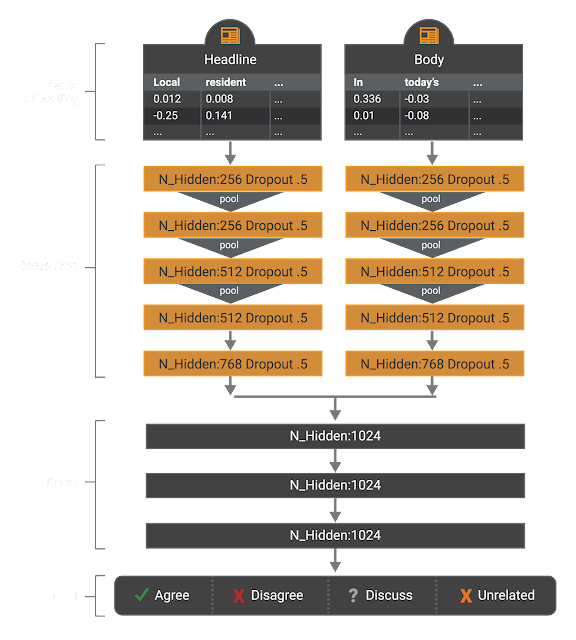

CNNS ENABLE EFFICIENT, EFFECTIVE PARALLEL COMPUTATION WHILE PERFORMING THIS CNN'S OUTPUT IS THEN SENT TO AN MULTI-LAYER PERCEPTRON (MLP) WITH 4-CLASS OUTPUT — "AGREE," "DISAGREE," "DISCUSS," AND "UNRELATED" — AND TRAINED END-TO-END. ALL CONVOLUTIONAL LAYERS USED DROPOUT (P=.5) TO REGULARIZE THE MODEL. Nevertheless, none of the model's hyperparameters were further evaluated to identify better options; instead, they were all set to sensible defaults.

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, concatenate
from keras.models import Model
from keras.utils import to_categorical


In [ ]:
# Load the data into a Pandas dataframe.
df_content = pd.read_csv('train_bodies.csv')
df_headline = pd.read_csv('train_stances.csv')

df = pd.merge(df_content, df_headline, on="Body ID")

In [ ]:
import json

MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['Headline'].values)
word_index = tokenizer.word_index
X_headline = tokenizer.texts_to_sequences(df['Headline'].values)
X_headline = pad_sequences(X_headline, maxlen=MAX_SEQUENCE_LENGTH)

# Save the tokenizer to a file
with open('tokenizer_head.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['articleBody'].values)
word_index = tokenizer.word_index
X_article = tokenizer.texts_to_sequences(df['articleBody'].values)
X_article = pad_sequences(X_article, maxlen=MAX_SEQUENCE_LENGTH)

with open('tokenizer_body.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())

Y = pd.get_dummies(df['Stance']).values


In [ ]:
df['Stance']

0        unrelated
1        unrelated
2        unrelated
3        unrelated
4        unrelated
           ...    
49967        agree
49968        agree
49969        agree
49970        agree
49971        agree
Name: Stance, Length: 49972, dtype: object

In [ ]:
Y[49971]

array([0, 0, 0, 1], dtype=uint8)

In [ ]:
VALIDATION_SPLIT = 0.2

indices = np.arange(X_headline.shape[0])
np.random.shuffle(indices)
X_headline = X_headline[indices]
X_article = X_article[indices]
Y = Y[indices]
nb_validation_samples = int(VALIDATION_SPLIT * X_headline.shape[0])

x_headline_train = X_headline[:-nb_validation_samples]
x_article_train = X_article[:-nb_validation_samples]
y_train = Y[:-nb_validation_samples]
x_headline_test = X_headline[-nb_validation_samples:]
x_article_test = X_article[-nb_validation_samples:]
y_test = Y[-nb_validation_samples:]


In [ ]:
EMBEDDING_DIM = 100
N_FILTERS = 128
FILTER_SIZE = 5
POOL_SIZE = 4
EPOCHS = 5
BATCH_SIZE = 32

input_headline = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_headline = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_headline)
conv_headline = Conv1D(N_FILTERS, FILTER_SIZE, activation='relu')(embedding_headline)
pool_headline = MaxPooling1D(POOL_SIZE)(conv_headline)
flatten_headline = Flatten()(pool_headline)

input_article = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_article = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_article)
conv_article = Conv1D(N_FILTERS, FILTER_SIZE, activation='relu')(embedding_article)
pool_article = MaxPooling1D(POOL_SIZE)(conv_article)
flatten_article = Flatten()(pool_article)

merged = concatenate([flatten_headline, flatten_article])
dropout_layer = Dropout(0.5)(merged)
outputs = Dense(Y.shape[1], activation='softmax')(dropout_layer)

model = Model(inputs=[input_headline, input_article], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit(x=[x_headline_train, x_article_train], y=y_train, validation_data=([x_headline_test, x_article_test], y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 100)     5000000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 100)     5000000     ['input_2[0][0]']                
                                                                                              

In [ ]:
score, acc = model.evaluate([x_headline_test, x_article_test], y_test, batch_size=BATCH_SIZE)
print('Test score:', score)
print('Test accuracy:', acc)


313/313 [==============================] - 14s 45ms/step - loss: 0.4721 - accuracy: 0.8281
Test score: 0.4720973074436188
Test accuracy: 0.828096866607666


In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/cnn_pretrain')

In [ ]:
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('saved_model/cnn_pretrain')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 250, 100)     5000000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 100)     5000000     ['input_2[0][0]']                
                                                                                              

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/saved_model" "/content/drive/MyDrive/cnn_pretrain"

In [ ]:
# # Evaluate the restored model
# loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(new_model.predict(test_images).shape)

In [ ]:
new_headline = "Study finds that coffee is good for your health"
new_article = "A new study has found that drinking coffee can reduce the risk of heart disease and liver cancer. The study, which was published in the Journal of the American Medical Association, followed over 500,000 people for over 10 years. The researchers found that people who drank 3 to 5 cups of coffee per day had a 15% lower risk of heart disease and a 27% lower risk of liver cancer compared to those who didn't drink coffee. The study also found that decaffeinated coffee had similar health benefits as regular coffee."

In [ ]:
import json
from keras.preprocessing.text import tokenizer_from_json

# Load the tokenizer from file
with open('tokenizer_head.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
# Convert the new data to sequences of integers
new_headline_seq = tokenizer.texts_to_sequences([new_headline])[0]
# Pad the sequences to have the same length
new_headline_seq = pad_sequences([new_headline_seq], maxlen=MAX_SEQUENCE_LENGTH)

with open('tokenizer_body.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
new_article_seq = tokenizer.texts_to_sequences([new_article])[0]
new_article_seq = pad_sequences([new_article_seq], maxlen=MAX_SEQUENCE_LENGTH)

# Preprocess the new data (assume new_headline and new_article are already preprocessed)
new_data = [new_headline_seq, new_article_seq]
# Make predictions
y_pred = model.predict(new_data)

# Get the predicted class
predicted_class = np.argmax(y_pred)

# Get the predicted probability for each class
predicted_probabilities = y_pred[0]

# Print the predicted class and probability for each class
print("Predicted class: ", predicted_class)
print("Predicted probabilities: ", predicted_probabilities)


1/1 [==============================] - 0s 22ms/step
Predicted class:  3
Predicted probabilities:  [0.26960257 0.04114856 0.08013908 0.6091097 ]


## BERT Implementation

BERT is a advanced pre-trained word embedding model based on transformer encoded architecture. We utilize BERT as a sentence encoder, which can accurately get the context representation of a sentence. BERT removes the unidirectional constraint using a mask language model (MLM). It randomly masks some of the tokens from the input and predicts the original vocabulary id of the masked word based only. MLM has increased the capability of BERT to outperforms as compared to previous embedding methods. It is a deeply bidirectional system that is capable of handling the unlabelled text by jointly conditioning on both left and right context in all layers. In this research, we have extracted embeddings for a sentence or a set of words or pooling the sequence of hidden-states for the whole input sequence. A deep bidirectional model is more powerful than a shallow left-to-right and right-to-left model.

In [ ]:
!pip install transformers


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


In [3]:
# Load the data into a Pandas dataframe.
df_content = pd.read_csv('train_bodies.csv')
df_headline = pd.read_csv('train_stances.csv')


In [4]:
df = pd.merge(df_content, df_headline, on="Body ID")

In [5]:
df

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [6]:
feature = df[['articleBody', 'Headline']]
feature

,articleBody,Headline
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun..."
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...
...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00..."
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip"
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip"
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...


In [7]:
data_classes = ["unrelated", "discuss","disagree","agree"]
label = df['Stance'].apply(data_classes.index)

In [8]:
#Test datasset
# Load the data into a Pandas dataframe.
df_content_test = pd.read_csv('test_bodies.csv')
df_headline_test = pd.read_csv('true_test_stances.csv')

df_test = pd.merge(df_content_test, df_headline_test, on="Body ID")

feature_test = df_test[['articleBody', 'Headline']]

data_classes_test = ["unrelated", "discuss","disagree","agree"]
labels_test = df_test['Stance'].apply(data_classes_test.index)


In [ ]:
# Split the data into train and test sets.
train_text, val_text, train_labels, val_labels = train_test_split(feature.iloc[:40000], label.iloc[:40000], test_size=0.2, random_state=42)

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the text inputs.
train_tokens = tokenizer.batch_encode_plus(
    train_text.values.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

test_tokens = tokenizer.batch_encode_plus(
    feature_test.values.tolist(),
    max_length = 512,
    padding=True,
    truncation=True
)

# Convert the tokenized inputs to PyTorch tensors.
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(labels_test.values.tolist())

# Create a DataLoader for our training set.
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=16)

# Create a DataLoader for our test set.
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)


In [10]:
# Load the pre-trained BERT model for sequence classification.
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False
)

# Define the optimizer and learning rate scheduler.
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
!nvidia-smi

Sun Apr 16 21:53:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
import torch
torch.cuda.is_available()

True

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set the model to the device (GPU or CPU).
model.to(device)

# Train the model.
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    
    # Set the model to training mode.
    model.train()
    
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Unpack the batch.
        batch_seq, batch_mask, batch_y = batch
        
        # Set the batch to the device.
        batch_seq = batch_seq.to(device)
        batch_mask = batch_mask.to(device)
        batch_y = batch_y.to(device)
        
        # Zero out any gradients.
        model.zero_grad()
        
        # Perform a forward pass.
        outputs = model(batch_seq, attention_mask=batch_mask, labels=batch_y)
        loss = outputs[0]
        total_loss += loss.item()
         
        # Perform a backward pass and optimize. 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    # Calculate the average loss for this epoch.
    avg_loss = total_loss / len(train_dataloader)
    print('Average loss: {:.2f}'.format(avg_loss))




Epoch 1/3
----------
Average loss: 0.28

Epoch 2/3
----------
Average loss: 0.11

Epoch 3/3
----------
Average loss: 0.05


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
#Finally, we'll evaluate the model on the test set:

# Set the model to evaluation mode.
model.eval()

# Create lists to store the predictions and true labels.
preds = []
true_labels = []

# Evaluate the model on the test set.
for batch in test_dataloader:
    # Unpack the batch.
    batch_seq, batch_mask, batch_y = batch
    
    # Set the batch to the device.
    batch_seq = batch_seq.to(device)
    batch_mask = batch_mask.to(device)
    batch_y = batch_y.to(device)
    
    # Disable gradient calculations.
    with torch.no_grad():
        # Perform a forward pass.
        outputs = model(batch_seq, attention_mask=batch_mask)
        logits = outputs[0]
        probs = torch.softmax(logits, dim=1)
        preds.extend(torch.argmax(probs, dim=1).tolist())
        true_labels.extend(batch_y.tolist())

# Calculate the F1 score and accuracy on the test set.
f1 = f1_score(true_labels, preds, average='weighted')
acc = accuracy_score(true_labels, preds)

print('F1 score: {:.2f}'.format(f1))
print('Accuracy: {:.2f}'.format(acc))


F1 score: 0.90
Accuracy: 0.91


In [18]:
model.save_pretrained('pretrained_model/')

In [19]:
!cp -r "/content/pretrained_model" "/content/drive/MyDrive/fakenews_pretrain"

In [20]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
unique_labels = set()

tester = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/fakenews_pretrain')

ids_to_labels = {0:"unrelated", 1:"discuss", 2:"disagree", 3:"agree"}

data = {'articleBody':["Path to save in drive can be found easily by clicking files on left side, navigating to folder and right click to choose Copy path. This will save the image to folder named Delete in Google Drive."], 'Headline':["How do I save files from Google Colab to Google Drive"]}
df_one = pd.DataFrame(data)
def evaluate_one_text(model, sentence):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer.batch_encode_plus(sentence.values.tolist(), padding='max_length', max_length = 512, truncation=True)

    # Convert the tokenized inputs to PyTorch tensors.
    input_id = torch.tensor(text['input_ids']).to(device)
    mask = torch.tensor(text['attention_mask']).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    print(sentence)
    print(prediction_label)
            
evaluate_one_text(tester, df_one)

                                         articleBody  \
0  Path to save in drive can be found easily by c...   

                                            Headline  
0  How do I save files from Google Colab to Googl...  
['agree']
